# CNN Model

In [1]:
# standard
#import cv2
import numpy as np
import pandas as pd
import os
import json
import csv
import random
import string
import shutil

# tf and keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
# Enable eager execution for TensorFlow data functions
tf.data.experimental.enable_debug_mode()
from tensorflow import keras
from keras.models import Sequential
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Conv2D, Flatten
from keras import metrics
tf.get_logger().setLevel('INFO')
tf.config.run_functions_eagerly(True)

# plots and images
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image
sns.set(style="darkgrid")  # default style
from keras.preprocessing.image import ImageDataGenerator
%matplotlib inline


np.random.seed(0)

``Pre-processing: Create combined file directory``


In [2]:
# Define your base directory
# this is where your data files are located containing 'train' and 'test' subfolders. 
# within each subfolder contains Drowsy and NonDrowsy images

# base data directory
base_dir = '../../207_project_files/data/'

In [3]:
# randomize file names
import os
import csv
import random
import string

np.random.seed(0)

def randomize_file_names (dir_path, mapping_file_name, true_labels=True):

  # create a list of all the files in the directory
  files = os.listdir(dir_path)

  # create a dictionary to store the new file names
  file_mapping = {}

  #print("files directory: ", files)
  # loop through each file in the directory
  for file in files:
      #print("file: ",file)
      if file.lower().endswith(('.jpeg', '.jpg', '.png')):
        # generate a random string of 10 characters
        new_name = ''.join(random.choices(string.ascii_uppercase + string.digits, k=10))
        # get the file extension
        ext = os.path.splitext(file)[1]
        # create the new file name with the random string and the original file extension
        new_file_name = new_name + ext
        # rename the file
        os.rename(os.path.join(dir_path, file), os.path.join(dir_path, new_file_name))
        
        # add the old and new file names to the dictionary
        #file_mapping[file] = new_file_name
        
        if true_labels:  
          #file_mapping[file] = 1
          label = 1
        else:
          #file_mapping[file] = 0
          label = 0

          # Create a nested dictionary to store old file name, new file name, and label
        file_mapping[file] = {
            'old_file_name': file,
            'new_file_name': new_name,
            'label': label
        }
         
  #print(mapping_file_name)
      
  # write the file mapping to a csv file
  with open(mapping_file_name, 'w', newline='') as csvfile:
      writer = csv.writer(csvfile)
      writer.writerow(['img_name', 'drowsiness'])
      
      for key, nested_dict in file_mapping.items():
          #print("old file name: ",key,"\tnew file name:",nested_dict['new_file_name'],"\tlabel:",nested_dict['label'])
          #base_name, _ = os.path.splitext(key)
          new_name = nested_dict['new_file_name']
          label = nested_dict['label']
          #print("old file name: ",base_name,"\tnew file name: ",new_file_name)
          #print("old file name: ",base_name,"\tnew file name: ",new_file_name)
          writer.writerow([new_name, label])

# Generate CSV to keep track of postives
randomize_file_names (base_dir + "/Drowsy/", base_dir + 'labels_pos.csv', true_labels=True)

# Generate CSV to keep track of negatives
randomize_file_names (base_dir + "/NonDrowsy/", base_dir + 'labels_neg.csv', true_labels=False)


In [4]:
# Create labels file

# Open the output CSV file in write mode
with open(base_dir + '/labels.csv', 'w', newline='') as outfile:
    writer = csv.writer(outfile)

    # Write the header from the first file (assuming both files have the same structure)
    with open(base_dir + 'labels_pos.csv', 'r') as infile1:
        reader1 = csv.reader(infile1)
        header1 = next(reader1)
        writer.writerow(header1)

    rows1 = [row for row in csv.reader(open(base_dir + 'labels_pos.csv', 'r'))]

    # Store rows from the second file in a list
    rows2 = [row for row in csv.reader(open(base_dir + 'labels_neg.csv', 'r'))]

    # Combine the rows from both files
    all_rows = rows1[1:] + rows2[1:]  # Skip the header row

    # Shuffle the combined rows
    #random.shuffle(all_rows)

    # Write the shuffled rows to the output CSV file
    for row in all_rows:
        writer.writerow(row)


In [5]:
combined_dir = os.path.join(base_dir, 'combined')
print(combined_dir)

# create the combined directory if it doesn't already exist
#combined_dir = base_dir + 'combined'
if not os.path.exists(combined_dir):
    os.makedirs(combined_dir)

# Delete all files in the combined directory
file_list = os.listdir(combined_dir)
for file_name in file_list:
    file_path = os.path.join(combined_dir, file_name)
    if os.path.isfile(file_path):
        os.remove(file_path)

../../207_project_files/data/combined


In [6]:

# copy all files base_dir/Drowsy to combined_dir
drowsy_dir = os.path.join(base_dir, 'Drowsy')
for file_name in os.listdir(drowsy_dir):
    file_path = os.path.join(drowsy_dir, file_name)
    if os.path.isfile(file_path):
        shutil.copy(file_path, combined_dir)

# copy all files base_dir/NonDrowsy to combined dir
non_drowsy_dir = os.path.join(base_dir, 'NonDrowsy')
for file_name in os.listdir(non_drowsy_dir):
    file_path = os.path.join(non_drowsy_dir, file_name)
    if os.path.isfile(file_path):
        shutil.copy(file_path, combined_dir)

In [7]:
# Keep only .png or jpeg files

# Iterate over files in the directory
for file_name in os.listdir(combined_dir):
    file_path = os.path.join(combined_dir, file_name)

    # Check if the file is a regular file and does not end with '.png' or '.jpeg'
    if os.path.isfile(file_path) and not (file_name.endswith('.png') or file_name.endswith('.jpeg')):
        os.remove(file_path)  # Delete the file

### Read Data for Y labels

In [8]:
# Ready labels
y = pd.read_csv(
    base_dir + 'labels.csv'
)

print(y)
print(y.shape)

        img_name  drowsiness
0     WVQWP53ILZ           1
1     7MEFM0I7BJ           1
2     ES7W2LCD7R           1
3     CBY67JM7OB           1
4     P38Y7K9IWR           1
...          ...         ...
9856  7YODI6WBYY           0
9857  AUHARIUMDD           0
9858  HNWPUIERYM           0
9859  RS27PJSIHZ           0
9860  42O3CK8OZR           0

[9861 rows x 2 columns]
(9861, 2)


In [10]:
y.shape

(9861, 2)

In [11]:

y

,img_name,drowsiness
0,WVQWP53ILZ,1
1,7MEFM0I7BJ,1
2,ES7W2LCD7R,1
3,CBY67JM7OB,1
4,P38Y7K9IWR,1
...,...,...
9856,7YODI6WBYY,0
9857,AUHARIUMDD,0
9858,HNWPUIERYM,0
9859,RS27PJSIHZ,0


``Pre-process Data: correcting for data imbalances ``

In [12]:

np.random.seed(0)
sample_size = 50

non_drowsy = y[y.drowsiness == 0]
drowsy = y[y.drowsiness == 1]

# randomly draw images from each classe
non_drowsy_list = list(np.random.choice(
    non_drowsy.img_name,
    size=sample_size,
    replace=False
))

drowsy_list = list(np.random.choice(
    drowsy.img_name,
    size=sample_size,
    replace=False
))

In [13]:
# inspect first five non drowsy results
non_drowsy_list[:5]

['KLAA38H81A', '563O2BLKM8', 'NK83FSD630', 'HMUY64O3LL', '9JVPE5TSVL']

In [14]:
# inspect first five drowsy results
drowsy_list[:5]

['CQRSR862TG', 'V8B2JMF9DX', 'SNFSQD7LIJ', 'TKCLTN5SPH', '9OE9UGG8EZ']

In [15]:
# set image resolutions
X_RES = 64
Y_RES = 64

In [16]:
def preprocess_data_part1(IMAGE_PATH, LABEL_PATH):
    """ Generate lists of images and labelsbased on temp_no_refer and temp_refer lists
    
    Params:
    -------
    IMAGE_PATH (str): path to directory with images.
    LABEL_PATH (str): path to directory with labels.
    
    Returns:
    --------
    images_mini  (np.ndarray): Images of shape (N, 224, 224, 3)
    y_mini (np.ndarray): Labels of shape (N,)    
    """
    y_mini = []
    images_mini = []

    # create lists of images and labels `images_mini` and `y_mini` 
    # based on temp_no_refer and temp_refer selections
    for idx, img in enumerate(os.listdir(IMAGE_PATH)):
        # read labels
        if img.split('.')[0] in non_drowsy_list:
                y_mini.append(0)
        elif img.split('.')[0] in drowsy_list:
                y_mini.append(1)
        else:
            continue

        
        # read image
        img = load_img(
            IMAGE_PATH + img,
            target_size=(X_RES, Y_RES)
        )
        
        # transform image to array
        img = img_to_array(img)

        # append to images
        images_mini.append(img)

    # stack images and trasnform to array
    images_mini = np.stack(images_mini)
    y_mini = np.array(y_mini).flatten() 
    
    return images_mini, y_mini

In [17]:
# generate images and labels based on preprocess_data_part1() function
#images_mini, y_mini = preprocess_data_part1(combined_dir, base_dir, drowsy=drowsy, non_drowsy=non_drowsy)
#images_mini, y_mini = preprocess_data_part1(IMAGE_PATH, LABEL_PATH)
images_mini, y_mini = preprocess_data_part1(combined_dir +"/", base_dir)

print(f"images_mini shape {images_mini.shape}")
print(f"y_mini shape {y_mini.shape}")

images_mini shape (100, 64, 64, 3)
y_mini shape (100,)


In [18]:
y_mini
#len(y_mini)

array([1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0,
       1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0,
       0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1])

2023-11-24 16:14:18.411137: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


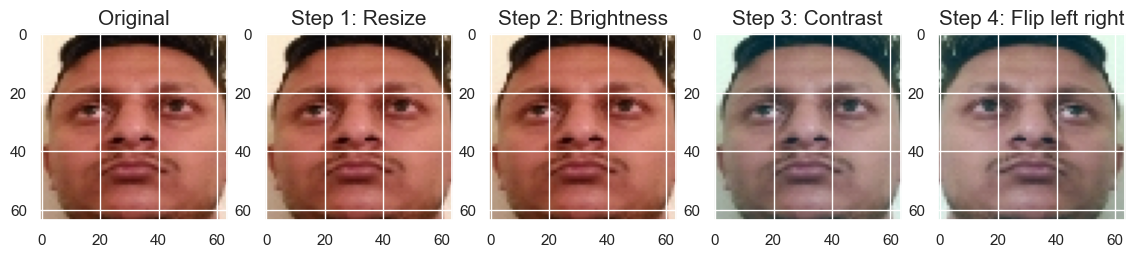

In [19]:
tf.random.set_seed(0)

fig = plt.figure(figsize=(14, 12))

# pull first image from data
image = images_mini[0]

# plot original
ax = fig.add_subplot(1, 5, 1)
ax.imshow(array_to_img(image))
ax.set_title('Original', size=15);

# resize
ax = fig.add_subplot(1, 5, 2)
img_resize = tf.image.resize(image, size=(X_RES, Y_RES))
ax.imshow(array_to_img(img_resize))
ax.set_title('Step 1: Resize', size=15);


# adjust brightness
ax = fig.add_subplot(1, 5, 3)
img_bright = tf.image.adjust_brightness(img_resize, 0.3)
ax.imshow(array_to_img(img_bright))
ax.set_title('Step 2: Brightness', size=15);


# adjust contrast
ax = fig.add_subplot(1, 5, 4)
img_contrast = tf.image.adjust_contrast(img_bright, contrast_factor=3)
ax.imshow(array_to_img(img_contrast))
ax.set_title('Step 3: Contrast', size=15);


# flip left right
ax = fig.add_subplot(1, 5, 5)
img_flip = tf.image.flip_left_right(img_contrast)
ax.imshow(array_to_img(img_flip))
ax.set_title('Step 4: Flip left right', size=15);

In [20]:
#IMAGE_SIZE = (224, 224)
IMAGE_SIZE = (X_RES, Y_RES)
CONTRAST_FACTOR = 3
DELTA = 0.3
flip = 'yes'


def preprocess_data_part2(images, y, split=(0.6,0.2,0.2)):
    """ Split data into train, validation and test sets; apply transformaions and augmentations
    
    Params:
    -------
    images  (np.ndarray): Images of shape (N, 224, 224, 3)
    y (np.ndarray): Labels of shape (N,)   
    split (tuple): 3 values summing to 1 defining split of train, validation and test sets
    
    Returns:
    --------
    X_train (np.ndarray): Train images of shape (N_train, 224, 224, 3)
    y_train (np.ndarray): Train labels of shape (N_train,)
    X_val (np.ndarray): Val images of shape (N_val, 224, 224, 3)
    y_val (np.ndarray): Val labels of shape (N_val,)
    X_test (np.ndarray): Test images of shape (N_test, 224, 224, 3)
    y_test (np.ndarray): Test labels of shape (N_test,)
    
    """
    
    ### create train/validation/test sets ###
    #########################################
    # NOTE: Each time you run this cell, you'll re-shuffle the data. The ordering will be the same due to the random seed generator 
    tf.random.set_seed(0)
    np.random.seed(0)
    shuffle = np.random.permutation(np.arange(images.shape[0]))
    images, y = images[shuffle], y[shuffle]
    
    #splits = np.multiply(len(images_mini), split).astype(int)
    splits = np.multiply(len(y), split).astype(int)
    X_train, X_val, X_test = np.split(images_mini, [splits[0], splits[0]+splits[1]])
    #X_train, X_val, X_test = np.split(y, [splits[0], splits[0]+splits[1]])
    y_train, y_val, y_test = np.split(y_mini, [splits[0], splits[0]+splits[1]])
    
    ### image transformation on training, validation, and test data ###
    ###################################################################
    # image resize
    X_train = tf.image.resize(X_train, size=IMAGE_SIZE)
    X_val = tf.image.resize(X_val, size=IMAGE_SIZE)
    X_test = tf.image.resize(X_test, size=IMAGE_SIZE)
    
    # rescale image to [0,1], i.e., greyscale
    X_train = X_train/255.0
    X_val = X_val/255.0
    X_test = X_test/255.0
    
    
    ### image augmentation on training data ###
    ###########################################
    # adjust brightness
    X_train_augm = tf.image.adjust_brightness(X_train, delta=DELTA)
    
    # adjust contrast
    X_train_augm = tf.image.adjust_contrast(X_train_augm, contrast_factor=CONTRAST_FACTOR)

    #if flip == 'yes':
        # random flip
    X_train_augm = tf.image.random_flip_left_right(X_train_augm)
    
    # concatenate original X_train and augmented X_train data
    X_train = tf.concat([X_train, X_train_augm],axis=0)
    
    # concatenate y_train (note the label is preserved)
    y_train_augm = y_train
    y_train = tf.concat([y_train, y_train_augm],axis=0)
    
    # shuffle X_train and y_train, i.e., shuffle two tensors in the same order
    shuffle = tf.random.shuffle(tf.range(tf.shape(X_train)[0], dtype=tf.int32))
    X_train = tf.gather(X_train, shuffle)
    y_train = tf.gather(y_train, shuffle).numpy() #also transforms y_train to numpy array
    
    return X_train, y_train, X_val, y_val, X_test, y_test

``Create Train + validation and test data ``


In [21]:
X_train, y_train, X_val, y_val, X_test, y_test = preprocess_data_part2(
    images_mini,
    y_mini,
    split=(0.6,0.2,0.2)
)

print(f"X_train shape {X_train.shape}")
print(f"y_train shape {y_train.shape}")
print(f"X_val shape {X_val.shape}")
print(f"y_val shape {y_val.shape}")
print(f"X_test shape {X_test.shape}")
print(f"y_test shape {y_test.shape}")

X_train shape (120, 64, 64, 3)
y_train shape (120,)
X_val shape (20, 64, 64, 3)
y_val shape (20,)
X_test shape (20, 64, 64, 3)
y_test shape (20,)


In [22]:
import matplotlib.pyplot as plt

# create empty lists to store loss and epoch values
train_loss = []
val_loss = []
epochs = []

# define a function to update the plot
def update_plot(epoch, train_loss_value, val_loss_value):
    epochs.append(epoch)
    train_loss.append(train_loss_value)
    val_loss.append(val_loss_value)
    plt.plot(epochs, train_loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# define a callback to update the plot after every epoch
class PlotLossCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        update_plot(epoch, logs['loss'], logs['val_loss'])


### Base Model

``Build + Compile Model``

In [23]:
# build CNN model

def build_model2 (train_model=False):
    
    """ Buld tf.keras CNN model """
    
    # clear session and remove randomness to get reproducible results
    tf.keras.backend.clear_session()
    tf.random.set_seed(0)
    np.random.seed(0)

    model = keras.Sequential()

    # convolution layer 1
    model.add(Conv2D(filters=32, 
                     kernel_size=(3,3),
                     strides=(1,1), 
                     padding='same',
                     data_format='channels_last',
                     name='conv_1',
                     input_shape=(Y_RES, X_RES, 3), 
                     activation='relu')) 
    
    # add max pooling to L1                 
    model.add(tf.keras.layers.MaxPool2D(
        pool_size=(2,2),
        name='pool_1'))
    

    # convolution layer 2
    model.add(Conv2D(filters=128,
                     kernel_size=(3,3),
                     strides=(1,1),
                     padding='same',
                     name='conv_2',
                     activation='relu'))
    
    # add max pooling to L2             
    model.add(tf.keras.layers.MaxPool2D(
        pool_size=(2,2),
        name='pool_2'))

    # if train_model:
    #     model.add(Dropout(0.2))

    # add a fully connected layer (need to flatten the output of the previous layers first)
    model.add(Flatten())
    model.add(Dense(units=384,
                    name='fc_1',
                    activation='relu'))
    
    # add dropout layer
    model.add(tf.keras.layers.Dropout(
        rate=0.5
    ))
    
    model.add(Dense(128, activation='relu'))
    
    model.add(Dense(32, activation='relu'))
    
    # output layer
    #model.add(Dense(2, activation='softmax'))
    #model.add(Dense(2, activation='sigmoid'))
    #model.add(Dense(1, activation='softmax'))
    model.add(Dense(1, activation=None))

    # Choose loss function
    # if opt == 'Adam':
    #     optimizer = keras.optimizers.Adam(learning_rate=lr)
    # elif opt == 'Adagrad':
    #     optimizer = keras.optimizers.Adagrad(learning_rate=lr)
    # else:
    #     optimizer = keras.optimizers.SGD(learning_rate=lr)

    #build model and print summary
    #tr.random.set_seed(0)

    
    # Compile model
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.003),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
              metrics=['accuracy']) 

    return model


In [24]:
# build model instance
#model = build_model2(train_model=True, opt='Adam', lr=0.01)
#model = build_model2(train_model=True, opt='Adam', lr=0.01)
model = build_model2(train_model=True)

# kernel size: 5,5; 3,3
# kernel size: 2,2; 1,1
# pool size: 3,3; 2,2
# lr: 0.01, 0.001
# brightness (delta): 
# contrast factor (delta): 

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 pool_1 (MaxPooling2D)       (None, 32, 32, 32)        0         
                                                                 
 conv_2 (Conv2D)             (None, 32, 32, 128)       36992     
                                                                 
 pool_2 (MaxPooling2D)       (None, 16, 16, 128)       0         
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 fc_1 (Dense)                (None, 384)               12583296  
                                                                 
 dropout (Dropout)           (None, 384)               0

``Fit model``

In [25]:
history = model.fit(
          x=X_train, 
          y=y_train,
          epochs=10,
          validation_data=(X_val, y_val),
          verbose=1
    )

Epoch 1/10
4/4 [==============================] - 0s 108ms/step - loss: 3.7965 - accuracy: 0.5417 - val_loss: 0.6969 - val_accuracy: 0.4500
Epoch 2/10
4/4 [==============================] - 0s 104ms/step - loss: 0.7744 - accuracy: 0.4833 - val_loss: 0.6928 - val_accuracy: 0.4500
Epoch 3/10
4/4 [==============================] - 0s 93ms/step - loss: 0.6922 - accuracy: 0.5000 - val_loss: 0.6922 - val_accuracy: 0.4500
Epoch 4/10
4/4 [==============================] - 0s 96ms/step - loss: 0.6915 - accuracy: 0.5000 - val_loss: 0.6920 - val_accuracy: 0.4500
Epoch 5/10
4/4 [==============================] - 0s 93ms/step - loss: 0.6856 - accuracy: 0.5000 - val_loss: 0.6896 - val_accuracy: 0.4500
Epoch 6/10
4/4 [==============================] - 0s 106ms/step - loss: 0.6656 - accuracy: 0.5000 - val_loss: 0.6892 - val_accuracy: 0.4500
Epoch 7/10
4/4 [==============================] - 0s 96ms/step - loss: 0.6431 - accuracy: 0.5250 - val_loss: 0.6806 - val_accuracy: 0.4500
Epoch 8/10
4/4 [========

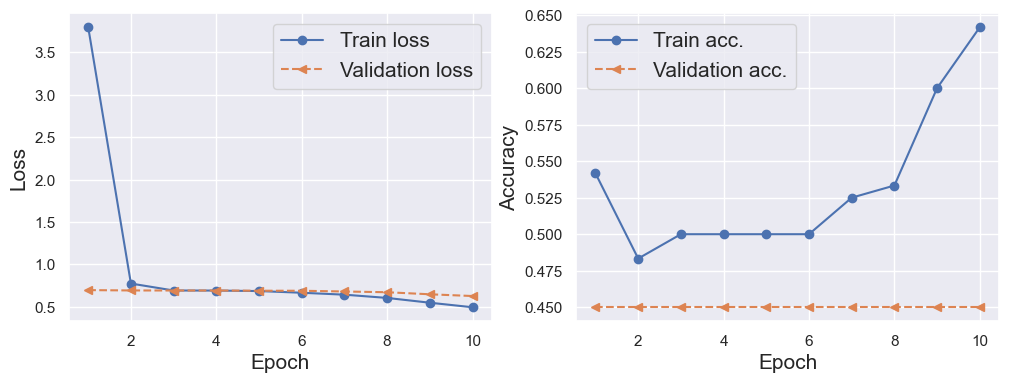

In [26]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
plt.show()

### Experimental Model

In [27]:

#optimizers = ['Adam', 'Adagrad', 'SGD']
optimizers = ['Adam']
#learning_rates = [0.003]
learning_rates = [0.001, 0.003, 0.005, 0.008]
#kernel_sizes = [(2,2), (3,3), (5,5)]
kernel_sizes = [(1,1), (2,2)]
drop_rate = [0.2, 0.3, 0.5]
#kernel_sizes = [(3,3), (5,5)]

stride_sizes = [(1,1), (2,2)]
pool_sizes = [(2,2), (3,3)]

In [28]:
# build CNN model

def build_model (train_model=False, 
                 lr=0.001, 
                 opt='Adam', 
                 k_size=(3,3), 
                 str_size=(1,1),
                 p_size=(2,2),
                 drop_rate=0.5
                 ):
    
    """ Buld tf.keras CNN model """
    
    # clear session and remove randomness to get reproducible results
    tf.keras.backend.clear_session()
    tf.random.set_seed(0)
    np.random.seed(0)

    model = keras.Sequential()

    # convolution layer 1
    model.add(Conv2D(filters=32, 
                     kernel_size=k_size,
                     strides=str_size, 
                     padding='same',
                     data_format='channels_last',
                     name='conv_1',
                     input_shape=(Y_RES, X_RES, 3), 
                     activation='relu')) 
    
    # add max pooling to L1                 
    model.add(tf.keras.layers.MaxPool2D(
        pool_size=p_size,
        name='pool_1'))

    # convolution layer 2
    model.add(Conv2D(filters=128,
                     kernel_size=k_size,
                     strides=str_size,
                     padding='same',
                     name='conv_2',
                     activation='relu'))
    
    # add max pooling to L2             
    model.add(tf.keras.layers.MaxPool2D(
        pool_size=p_size,
        name='pool_2'))

    # if train_model:
    #     model.add(Dropout(0.2))

    # add a fully connected layer (need to flatten the output of the previous layers first)
    model.add(Flatten())
    model.add(Dense(units=384,
                    name='fc_1',
                    activation='relu'))
    
    # add dropout layer
    model.add(tf.keras.layers.Dropout(
        rate=drop_rate
    ))
    
    model.add(Dense(128, activation='relu'))
    
    model.add(Dense(32, activation='relu'))
    
    # output layer
    #model.add(Dense(2, activation='softmax'))
    #model.add(Dense(1, activation='sigmoid'))
    #model.add(Dense(1, activation='softmax'))
    model.add(Dense(1, activation=None))

    #Choose loss function
    if opt == 'Adam':
        optimizer = keras.optimizers.Adam(learning_rate=lr)
    elif opt == 'Adagrad':
        optimizer = keras.optimizers.Adagrad(learning_rate=lr)
    else:
        optimizer = keras.optimizers.SGD(learning_rate=lr)

    #build model and print summary
    #tr.random.set_seed(0)

    
    # Compile model
    model.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
              metrics=['accuracy']) 
    # model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.003),
    #           loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
    #           metrics=['accuracy'])

    return model

In [29]:
#kernel_sizes[0]

In [30]:
# initialize dictionary for models
models = {}
run_count = 0


for opt in optimizers:
    for lr in learning_rates:
        for ksize in kernel_sizes:
            for rate in drop_rate:
                tf.random.set_seed(0)
                np.random.seed(0)
                

                # Build model based on params
                model = build_model(train_model=True,
                                    lr=lr,
                                    opt=opt,
                                    k_size=ksize,
                                    drop_rate=rate)
                
                models[run_count] = model
                #print(f"Model {run_count}.center(10,"-")")
                #print("hi".center(10,"-"))
                model_run = " model " + str(run_count) + " "
                print(model_run.center(20,"-"))
                #print("Blah".center(10,"-"))
                print("Optimizer: ",opt,"\tLearning Rate: ",lr,"\tKernel Size: ",ksize, "\tDrop out rate:",rate)

                #Fit model
                history = models[run_count].fit(
                    x=X_train, 
                    y=y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    verbose=0
                )

                # store each model's training and validation accuracy into dictionary
                models[run_count] = {'accuracy': history.history['accuracy'][-1:][0],
                                    'val_accuracy': history.history['val_accuracy'][-1:][0],
                                    'params': model.count_params(),
                                    'Loss': opt,
                                    'Learn Rate': lr,
                                    'kernel_size': ksize,
                                    'Dropout rate': rate,
                                    }
                
                #hist = pd.DataFrame(history.history)
                #model.summary()
                #plot_history(history)
                print(f"\t\tAccuracy: {history.history['accuracy'][-1:][0]:.4}\tValidation Accuracy: {history.history['val_accuracy'][-1:][0]:.4}")
                #print(f"Validation Accuracy: {history.history['val_accuracy'][-1:][0]}")
                print("\n")
                run_count += 1

----- model 0 ------
Optimizer:  Adam 	Learning Rate:  0.001 	Kernel Size:  (1, 1) 	Drop out rate: 0.2
		Accuracy: 0.85	Validation Accuracy: 0.8


----- model 1 ------
Optimizer:  Adam 	Learning Rate:  0.001 	Kernel Size:  (1, 1) 	Drop out rate: 0.3
		Accuracy: 0.8583	Validation Accuracy: 0.7


----- model 2 ------
Optimizer:  Adam 	Learning Rate:  0.001 	Kernel Size:  (1, 1) 	Drop out rate: 0.5
		Accuracy: 0.8583	Validation Accuracy: 0.75


----- model 3 ------
Optimizer:  Adam 	Learning Rate:  0.001 	Kernel Size:  (2, 2) 	Drop out rate: 0.2
		Accuracy: 0.8667	Validation Accuracy: 0.85


----- model 4 ------
Optimizer:  Adam 	Learning Rate:  0.001 	Kernel Size:  (2, 2) 	Drop out rate: 0.3
		Accuracy: 0.8333	Validation Accuracy: 0.85


----- model 5 ------
Optimizer:  Adam 	Learning Rate:  0.001 	Kernel Size:  (2, 2) 	Drop out rate: 0.5
		Accuracy: 0.8417	Validation Accuracy: 0.7


----- model 6 ------
Optimizer:  Adam 	Learning Rate:  0.003 	Kernel Size:  (1, 1) 	Drop out rate: 0.2
		

In [31]:
rows = []

for key, accuracy in models.items():
    row = {'Model': key}
    row.update(accuracy)
    rows.append(row)

# build final table
final_counts_table = pd.DataFrame(rows)
final_counts_table

,Model,accuracy,val_accuracy,params,Loss,Learn Rate,kernel_size,Dropout rate
0,0,0.850000,0.80,12641089,Adam,0.001,"(1, 1)",0.2
1,1,0.858333,0.70,12641089,Adam,0.001,"(1, 1)",0.3
2,2,0.858333,0.75,12641089,Adam,0.001,"(1, 1)",0.5
3,3,0.866667,0.85,12653665,Adam,0.001,"(2, 2)",0.2
4,4,0.833333,0.85,12653665,Adam,0.001,"(2, 2)",0.3
5,5,0.841667,0.70,12653665,Adam,0.001,"(2, 2)",0.5
6,6,0.833333,0.90,12641089,Adam,0.003,"(1, 1)",0.2
7,7,0.825000,0.85,12641089,Adam,0.003,"(1, 1)",0.3
8,8,0.916667,0.90,12641089,Adam,0.003,"(1, 1)",0.5
9,9,0.841667,0.65,12653665,Adam,0.003,"(2, 2)",0.2


In [32]:
final_counts_table['avg_acc'] = (final_counts_table['accuracy'] + final_counts_table['val_accuracy']) / 2

In [46]:
final_counts_table.sort_values('avg_acc',ascending=False)

,Model,accuracy,val_accuracy,params,Loss,Learn Rate,kernel_size,Dropout rate,avg_acc
12,12,0.883333,0.95,12641089,Adam,0.005,"(1, 1)",0.2,0.916667
8,8,0.916667,0.90,12641089,Adam,0.003,"(1, 1)",0.5,0.908333
14,14,0.950000,0.85,12641089,Adam,0.005,"(1, 1)",0.5,0.900000
11,11,0.866667,0.90,12653665,Adam,0.003,"(2, 2)",0.5,0.883333
13,13,0.858333,0.90,12641089,Adam,0.005,"(1, 1)",0.3,0.879167
19,19,0.800000,0.95,12641089,Adam,0.008,"(1, 1)",0.3,0.875000
18,18,0.941667,0.80,12641089,Adam,0.008,"(1, 1)",0.2,0.870833
6,6,0.833333,0.90,12641089,Adam,0.003,"(1, 1)",0.2,0.866667
16,16,0.825000,0.90,12653665,Adam,0.005,"(2, 2)",0.3,0.862500
3,3,0.866667,0.85,12653665,Adam,0.001,"(2, 2)",0.2,0.858333


``Fit model``

In [34]:
# #
# # = '/home/data/train/'


# batch_size = 16

# train_datagen = ImageDataGenerator(
#             #rescale=1.0, #/ 255,  # Rescale pixel values to [0, 1]
#             rescale=1./255,
#             rotation_range=5,  # Rotate images by up to 20 degrees
#             width_shift_range=0.2,  # Shift the width of the image by up to 20%
#             height_shift_range=0.2,  # Shift the height of the image by up to 20%
#             shear_range=0.2,  # Apply shear transformation
#             zoom_range=0.2,  # Zoom in by up to 20%
#             horizontal_flip=False,  # Flip images horizontally
#             fill_mode='nearest',  # Fill in missing pixels with the nearest value
#             validation_split=0.3
#         )



# train_generator = train_datagen.flow_from_directory(
#     train_dir,
#     target_size=(X_RES, Y_RES),
#     batch_size=batch_size,
#     class_mode='categorical',
#     subset='training',
#     shuffle=True,
#     color_mode='rgb'

# )

# validation_generator = train_datagen.flow_from_directory(
#     train_dir,
#     target_size=(X_RES, Y_RES),
#     batch_size=batch_size,
#     class_mode='categorical',
#     subset='validation',
#     shuffle=True,
#     color_mode='rgb'

# )

In [35]:
# tf.data.experimental.enable_debug_mode()


In [36]:
# from keras.callbacks import EarlyStopping
# early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


# # model.fit(
# #     train_generator,
# #     steps_per_epoch=train_generator.samples // batch_size,
# #     validation_data=validation_generator,
# #     validation_steps=validation_generator.samples // batch_size,
# #     epochs=20,|
# #     run_eagerly = True,
# #     callbacks=[PlotLossCallback()])
#     #callbacks=[PlotLossCallback(), early_stopping])
# model.fit(
#     train_generator,
#     steps_per_epoch=train_generator.samples // batch_size,
#     validation_data=validation_generator,
#     validation_steps=validation_generator.samples // batch_size,
#     epochs=20,
#     callbacks=[PlotLossCallback()]
# )

# model.summary()
# tf.config.run_functions_eagerly(True)

``Compile model``

In [37]:
# #import tensorflow as tf
# #tf.config.run_functions_eagerly(True)

# #from keras.callbacks import EarlyStopping
# #early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# #model.summary()

# # Uncomment to test without the custom callback
# callbacks = [early_stopping]
# #callbacks = [early_stopping, PlotLossCallback()]

# model.fit(
#     train_generator,
#     steps_per_epoch=train_generator.samples // batch_size,
#     validation_data=validation_generator)


``Fit model``

In [38]:
# for images, labels in train_generator:
#     print(images.shape, labels.shape)
#     break  # Check the first batch only


In [39]:
# model.save('/home/dd_model.h5')

In [40]:
# test_dir = '/home/data/test/'

# test_datagen = ImageDataGenerator(
#             #srescale=1.0 / 255,  # Rescale pixel values to [0, 1]
#         )

# test_generator = test_datagen.flow_from_directory(
#     test_dir,
#     target_size=(X_RES, Y_RES),
#     class_mode='categorical',
#     shuffle=True,
#     batch_size=batch_size,
#     color_mode='rgb'
# )

# test_loss, test_accuracy = model.evaluate(test_generator)
# print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

In [41]:
#model = keras.models.load_model('dd_model.h5')

# This section is to test custom images

In [42]:
# import  pandas as pd
# from IPython.display import display

# #dir_path = '/home/mayank/programs/mids/DriverDrowsiness/data/test/NonDrowsy/'

# dir_path = '/Users/mayank/Programs/mids_ml/mids/DriverDrowsiness/data/test_img/'

# def predict(model, img):
#     img= keras.utils.load_img(
#         img, target_size=(X_RES, Y_RES), color_mode='rgb')
#     img_array = keras.utils.img_to_array(img)
#     img_array = img_array / 255.0
#     img_array = tf.expand_dims(img_array, 0)  # Create batch axis
#     predictions = model.predict(img_array)

#     return predictions

# i = 0
# prediction_results = []
# for file_name in os.listdir(dir_path):

#     predictions = predict(model, dir_path+file_name)

#     dp, fn = os.path.split(dir_path)
#     prediction_results.append([os.path.basename(dp)+'/'+file_name, predictions[0][0], predictions[0][1]])
#     i = i + 1
#     if i == 100:
#         break

# df = pd.DataFrame(prediction_results, columns=['Filename', 'Drowsy', 'Non-Drowsy'])

# #df = pd.DataFrame(prediction_results, columns=['Filename', '1', '2', '3', '4'])


# display(df)

In [43]:
# import matplotlib.pyplot as plt

# import numpy as np
# import cv2
# import matplotlib.pyplot as plt
# from keras.layers import Conv2D
# from keras.models import Model
# import os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress most warnings

# import tensorflow as tf
# tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)  # Suppress TensorFlow v1.x warnings


# def plot_conv_layers(model, img_path):
#     # Load the image
#     img = cv2.imread(img_path)
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     img = cv2.resize(img, (X_RES, Y_RES))
#     img = np.expand_dims(img, axis=0)  # Expand dimensions to match model's input shape

#     # Get the output of each Conv2D layer
#     layer_outputs = [layer.output for layer in model.layers if isinstance(layer, Conv2D)]
#     activation_model = Model(inputs=model.input, outputs=layer_outputs)

#     # Get activations
#     activations = activation_model.predict(img)
#     layer_names = [layer.name for layer in model.layers if isinstance(layer, Conv2D)]

#    # Plot the output of each layer in a 1x3 grid
#     fig, axes = plt.subplots(1, 3, figsize=(15, 5))
#     for i, ax in enumerate(axes):
#         ax.imshow(activations[i][0, :, :, 0], cmap='gray')  # Displaying the 1st channel
#         ax.set_title(layer_names[i])
#         ax.axis('off')
#     plt.tight_layout()
#     plt.show()


# # Plot the convolved layers
# plot_conv_layers(model, '/home/mayank/Pictures/Webcam/test/face_2.jpg')

# plot_conv_layers(model, '/home/mayank/programs/mids/DriverDrowsiness/data/test/NonDrowsy/d0016.png')

# plot_conv_layers(model, '/home/mayank/programs/mids/DriverDrowsiness/data/test/NonDrowsy/c0417.png')

# plot_conv_layers(model, '/home/mayank/programs/mids/DriverDrowsiness/data/test/NonDrowsy/b0027.png')

# plot_conv_layers(model, '/home/mayank/programs/mids/DriverDrowsiness/data/test/NonDrowsy/a1023.png')